<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_11_A_2D_frame_example_geometry%2C_materials_and_loads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== DISPLACEMENTS ===
DOF  1:  0.000000e+00
DOF  2:  5.284281e+00
DOF  3:  4.405160e+00
DOF  4:  0.000000e+00
DOF  5:  0.000000e+00
DOF  6:  6.521739e-01
DOF  7: -6.521739e-01
DOF  8:  0.000000e+00
DOF  9:  0.000000e+00
DOF 10: -4.976907e-04
DOF 11: -5.892658e-04
DOF 12:  0.000000e+00

=== REACTIONS (prescribed DOFs) ===
DOF  1: -8.846154e+03
DOF  4: -6.153846e+03
DOF  5: -4.565217e+03
DOF  8:  4.565217e+03
DOF  9:  3.002230e+07
DOF 12:  2.258640e+07


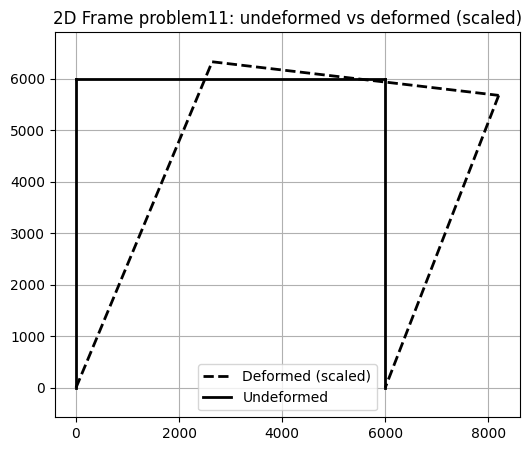

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 2D FRAME (problem11.m) - MATLAB -> Python (Google Colab)
# DOF order matches MATLAB code used in your screenshots:
#   [u1..un, v1..vn, theta1..thetan]
# ============================================================

def solution(GDof, prescribedDof, K, F):
    prescribed = np.array([d-1 for d in prescribedDof], dtype=int)  # 0-based
    all_dofs = np.arange(GDof)
    free = np.setdiff1d(all_dofs, prescribed)

    U = np.zeros(GDof)

    K_ff = K[np.ix_(free, free)]
    F_f  = F[free]

    U[free] = np.linalg.solve(K_ff, F_f)
    return U


def outputDisplacementsReactions(U, K, F, prescribedDof):
    R = K @ U - F

    print("=== DISPLACEMENTS ===")
    for i, ui in enumerate(U, start=1):
        print(f"DOF {i:2d}: {ui: .6e}")

    print("\n=== REACTIONS (prescribed DOFs) ===")
    for d in prescribedDof:
        print(f"DOF {d:2d}: {R[d-1]: .6e}")


def formStiffness2Dframe(GDof, numberElements, elementNodes, numberNodes, xx, yy, EI, EA):
    K = np.zeros((GDof, GDof))

    for e in range(numberElements):
        i, j = elementNodes[e, 0], elementNodes[e, 1]  # 1-based
        i = int(i); j = int(j)

        # MATLAB mapping:
        # elementDof = [indice, indice+numberNodes, indice+2*numberNodes]
        # where indice=[i j]
        elementDof = np.array([
            i-1, j-1,
            (i-1)+numberNodes, (j-1)+numberNodes,
            (i-1)+2*numberNodes, (j-1)+2*numberNodes
        ], dtype=int)

        xa = xx[j-1] - xx[i-1]
        ya = yy[j-1] - yy[i-1]
        L  = np.sqrt(xa*xa + ya*ya)

        cosa = xa / L
        sena = ya / L

        # Transformation matrix L (named T here)
        T = np.block([
            [ cosa*np.eye(2),  sena*np.eye(2), np.zeros((2,2)) ],
            [-sena*np.eye(2),  cosa*np.eye(2), np.zeros((2,2)) ],
            [ np.zeros((2,4)), np.eye(2) ]
        ])

        oneu  = np.array([[ 1, -1],
                          [-1,  1]], dtype=float)
        oneu2 = oneu.copy()
        oneu3 = np.array([[ 1,  1],
                          [-1, -1]], dtype=float)
        oneu4 = np.array([[4, 2],
                          [2, 4]], dtype=float)

        k_local = np.block([
            [ EA/L * oneu,                 np.zeros((2,2)),                  np.zeros((2,2)) ],
            [ np.zeros((2,2)), 12*EI/L**3 * oneu2,        6*EI/L**2 * oneu3 ],
            [ np.zeros((2,2)),  6*EI/L**2 * oneu3.T,      EI/L * oneu4     ]
        ])

        # Assemble
        K[np.ix_(elementDof, elementDof)] += T.T @ k_local @ T

    return K


def drawingMesh(nodeCoordinates, elementNodes, style='k--', label=None):
    for (n1, n2) in elementNodes:
        x = [nodeCoordinates[n1-1, 0], nodeCoordinates[n2-1, 0]]
        y = [nodeCoordinates[n1-1, 1], nodeCoordinates[n2-1, 1]]
        plt.plot(x, y, style, linewidth=2, label=label)
        label = None


# ============================================================
# MAIN (problem11.m)
# ============================================================

# Material / section
E = 210000.0
A = 200.0
I = 2e8
EA = E * A
EI = E * I

# Geometry & mesh
numberElements = 3
nodeCoordinates = np.array([
    [0.0,    0.0],
    [0.0, 6000.0],
    [6000.0, 6000.0],
    [6000.0, 0.0]
], dtype=float)

numberNodes = nodeCoordinates.shape[0]
xx = nodeCoordinates[:, 0]
yy = nodeCoordinates[:, 1]

# elementNodes: (1-2), (2-3), (3-4)
elementNodes = np.array([
    [1, 2],
    [2, 3],
    [3, 4]
], dtype=int)

GDof = 3 * numberNodes
F = np.zeros(GDof)

# Loads (MATLAB):
# force(2)=15000;  force(10)=10e6;
F[1] = 15000.0      # DOF2 (v1 in this DOF ordering? it's exactly MATLAB indexing)
F[9] = 10e6         # DOF10

# Stiffness
K = formStiffness2Dframe(GDof, numberElements, elementNodes, numberNodes, xx, yy, EI, EA)

# Boundary conditions (MATLAB: prescribedDof=[1 4 5 8 9 12]')
prescribedDof = [1, 4, 5, 8, 9, 12]

# Solve
U = solution(GDof, prescribedDof, K, F)

# Output
outputDisplacementsReactions(U, K, F, prescribedDof)

# Plot undeformed + deformed (MATLAB scale 500)
scale = 500.0
Ux = U[0:numberNodes]
Uy = U[numberNodes:2*numberNodes]

deformed = nodeCoordinates + scale * np.column_stack([Ux, Uy])

plt.figure(figsize=(6,5))
plt.axis('equal')
plt.grid(True)
plt.title("2D Frame problem11: undeformed vs deformed (scaled)")
drawingMesh(deformed, elementNodes, style='k--', label='Deformed (scaled)')
drawingMesh(nodeCoordinates, elementNodes, style='k-', label='Undeformed')
plt.legend()
plt.show()
